# Decision Tree for N-dimensional data and labels
The code below implements a **decision tree** calculated for labelled data as well as Random Forests.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm
from math import log, e
import random
import sys
import os
import matplotlib.image as mpimg
from IPython.core.display import Image, display
from tqdm import tqdm_notebook
from six.moves import reload_module

### Custom Libraries

In [2]:
from density_tree.decision_tree_create import *
from density_tree.create_data import *
from density_tree.plots import *

# Generic Functions
The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


In [3]:
class Node:
    """
    constructor for new nodes in a decision tree or density tree.
    decision rule is the rule which splits labels in two groups labels_left and labels_right
    left_rule and right_rule are pointers to the rules that have to be used
    to further split labels_left and labels_right
    """

    def __init__(self):
        # data for node
        self.parent = None  # parent node
        self.split_value = None  # the split value
        self.split_dimension = None  # the split dimension

        # labelled data
        self.labels = None  # the labels contained at this split level

        # unlabelled data
        self.entropy = None  # entropy, for unlabelled nodes
        self.dataset = None
        self.dataset_left = None
        self.dataset_right = None

        # child nodes
        self.left = None  # node to the left, e.g., for value < split_value
        self.right = None

        # labelled data
        self.left_labels = None
        self.right_labels = None

        # unlabelled data
        self.left_entropy = None
        self.right_entropy = None

    def get_root(self):
        if self.parent != None:
            return self.parent.get_root()
        else:
            return self

    def has_children(self):
        """print data for node"""
        if (self.right != None) & (self.right != None):
            return True
        return False

    def depth(self):
        """get tree depth"""
        left_depth = self.left.depth() if self.left else 0
        right_depth = self.right.depth() if self.right else 0
        return max(left_depth, right_depth) + 1

    def highest_entropy(self, node, e, side):
        """get the node in tree which has the highest entropy,
        taking a root node as input.
        for every node, check the entropies left and right after splitting
        if the node is not split yet to one of the sides and the entropy on the unsplit side
        exceeds the  maximum entropy, return the node.
        """
        if self.left_entropy is not None and self.left is None:
            if self.left_entropy > e:
                node = self
                e = self.left_entropy
                side = 'left'

        if self.right_entropy is not None and self.right is None:
            if self.right_entropy > e:
                node = self
                e = self.right_entropy
                side = 'right'

        if self.left is not None:
            node_lower_l, e_lower_l, side_lower_l = self.left.highest_entropy(node, e, side)
        if self.right is not None:
            node_lower_r, e_lower_r, side_lower_r = self.right.highest_entropy(node, e, side)
        if self.left is not None:
            if e_lower_l > e:
                node, e, side = node_lower_l, e_lower_l, side_lower_l
        if self.right is not None:
            if e_lower_r > e:
                node, e, side = node_lower_r, e_lower_r, side_lower_r

        return node, e, side

    """traversal methods"""

    def traverse_inorder(self):
        if self.left is not None:
            print('\n left')
            self.left.traverse_inorder()
        self.__format__()
        if self.right is not None:
            print('\n right')
            self.right.traverse_inorder()

    def traverse_preorder(self):
        self.__format__()
        if self.left is not None:
            print('\n left')
            self.left.traverse_preorder()
        if self.right is not None:
            print('\n right')
            self.right.traverse_preorder()

    def traverse_postorder(self):
        if self.left is not None:
            self.left.traverse_preorder()
            print('\n left')
        if self.right is not None:
            self.right.traverse_preorder()
            print('\n right')
        self.__format__()
        raise NotImplementedError

    def __format__(self):
        # print("rule: " + self.decisionrule) # print a decision rule on one line as a string (e.g., `d(2) < 20`)
        print("labels: " + str(self.labels))
        print("entropy: %.2f " % self.entropy)
        if self.has_children():
            print("split dimension: " + str(self.split_dimension))
            print("split value: %.2f " % self.split_value)


In [4]:
# %%writefile ./density_tree/density_tree.py

"""
unlabelled: working
"""
from . import *

def entropy_gaussian(S, base=2):
    """
    Differential entropy of a d-variate Gaussian density
    :param S: dataset in R^(N*D)
    :param base: base of entropy
    :return: entropy
    """
    K = np.linalg.det(np.cov(S.T))
    d = np.shape(S)[1]

    entropy = np.multiply(np.power(2 * np.pi * np.exp(1), d), K)
    if entropy <= 0:
        return 0
    entropy = np.log(entropy) / (np.log(base) * 2)
    if np.isnan(entropy):
        entropy = 0
    return entropy


"""
unlabelled: working
labelled: working
"""


def split(dataset, index, split_value, return_entropy=False):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value.
    :param dataset: input dataset
    :param index: index of dimension to split values on
    :param split_value: value of the dimension where the dataset is split
    :return: left and right split datasets
    """
    left, right = [], []
    for row in dataset:
        if row[index] < split_value:
            left.append(row)
        else:
            right.append(row)

    left = np.asarray(left)
    right = np.asarray(right)

    if return_entropy:
        e_left = entropy_gaussian(left)
        e_right = entropy_gaussian(right)
        return left, right, e_left, e_right
    else:
        return left, right


"""
labelled: ?
unlabelled: working
"""


def get_ig_dim(dataset, dim, entropy_f=entropy_gaussian, base=2, labelled=True):
    """
    for one dimension, get information gain
    :param dataset: dataset without labels (X)
    :param dim: dimension for which all cut values are to be calculated
    :param entropy_f: entropy function to be used (labelled / unlabelled)
    """
    ig_vals = []
    split_vals = []

    # loop over all possible cut values

    if labelled:
        iter_set = dataset[:, dim]  # e.g.: 3,5,1,2,6,10,4
    else:
        dataset_dim_min = np.min(dataset[:, dim])
        dataset_dim_max = np.max(dataset[:, dim])
        iter_set = np.linspace(dataset_dim_min, dataset_dim_max, 100)
        # iter_set = np.linspace(dataset[2, dim],dataset[-2, dim],100) # TODO remove 1:-2, find out why beginning and end cause crash

    for split_val in iter_set:
        # split values
        split_l = dataset[dataset[:, dim] < split_val]
        split_r = dataset[dataset[:, dim] >= split_val]

        # entropy
        entropy_l = entropy_f(split_l, base=base)
        entropy_r = entropy_f(split_r, base=base)
        entropy_tot = entropy_f(dataset, base=base)

        # information gain
        ig = entropy_tot - (entropy_l * len(split_l) / len(dataset) + entropy_r * len(split_r) / len(dataset))

        # append split value and information gain
        split_vals.append(split_val)
        ig_vals.append(ig)

    return np.array(ig_vals), np.array(split_vals)


'''
unlabelled: working
labelled: working
'''


def get_best_split(dataset, labelled=False):
    '''for a given dimension, get best split based on information gain'''
    # get all information gains on all dimensions
    ig_dims_vals, split_dims_vals = [], []

    if labelled:
        entropy_f = entropy
        dimensions = range(np.shape(dataset)[1] - 1)

    else:
        entropy_f = entropy_gaussian
        dimensions = range(np.shape(dataset)[1])

    for dim in dimensions:  # loop all dimensions
        ig_vals, split_vals = get_ig_dim(dataset, dim, entropy_f=entropy_f, labelled=labelled)
        ig_dims_vals.append(ig_vals)
        split_dims_vals.append(split_vals)

    # split dimension of maximum gain
    dim_max = np.argmax(np.max(ig_dims_vals, axis=1))

    # split value of maximum gain
    # get all maximum values and take the middle if there are several possible maximum values
    # TODO get mean best split value, then find corresponding index

    # middle_max_ind = np.where(np.equal(ig_dims_vals[dim_max],np.max(ig_dims_vals[dim_max])))
    # middle_max_ind = int(np.floor(np.mean(middle_max_ind)))
    middle_max_ind = np.argmax(ig_dims_vals[dim_max])
    val_dim_max = split_dims_vals[dim_max][middle_max_ind]

    return dim_max, val_dim_max, ig_dims_vals, split_dims_vals


"""
unlabelled: working
"""
def create_decision_tree_unlabelled(dataset, dimensions, clusters, parentnode=None, side_label=None):
    """create decision tree be performing initial split,
    then recursively splitting until all labels are in unique bins
    init: flag for first iteration
    Principle:  create an initial split, save value, dimension, and entropies on node as well as on both split sides
    As long as total number of splits < nclusters - 1, perform another split on the side having the higher entropy
    Or, if there are parent nodes: perform a split on the side of the node that has the highest entropy on a side
    """
    # split
    dim_max, val_dim_max, _, _ = get_best_split(dataset, labelled=False)
    left, right, e_left, e_right = split(dataset, dim_max, val_dim_max,
                                         return_entropy=True)  #  split along best dimension

    treenode = Node()  # initial node
    # save tree node
    treenode.split_dimension = dim_max
    treenode.split_value = val_dim_max
    treenode.dataset = dataset
    treenode.dataset_left = left
    treenode.dataset_right = right
    treenode.entropy = entropy_gaussian(dataset)
    treenode.left_entropy = e_left
    treenode.right_entropy = e_right

    # link parent node to new node.
    if parentnode is not None:
        treenode.parent = parentnode
        if side_label == 'left':
            parentnode.left = treenode
        elif side_label == 'right':
            parentnode.right = treenode

    clusters_left = clusters - 1
    if clusters_left > 1:
        # recursively continue splitting
        # continue splitting always splitting on worst side (highest entropy)
        # find node where left or right entropy is highest and left or right node is not split yet
        node_e, e, side = treenode.get_root().highest_entropy(dataset, 0, 'None')
        if side == 'left':
            dataset = node_e.dataset_left
            side_label = 'left'
        elif side == 'right':
            dataset = node_e.dataset_right
            side_label = 'right'

        create_decision_tree_unlabelled(dataset, dimensions, clusters=clusters_left, parentnode=node_e,
                                        side_label=side_label)  # iterate

    return treenode


# Labelled data

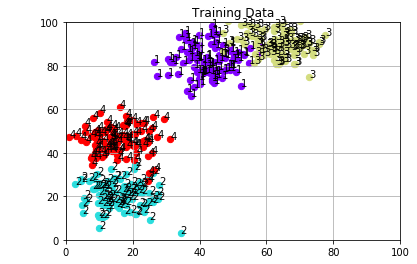

In [8]:
# cluster parameters
nclusters=4
dimensions=2
covariance=40
minRange=0
maxRange=100
npoints=100

    
dataset, clusters = createData(nclusters, dimensions, covariance, npoints, 
                                              minRange = minRange, maxRange = maxRange)

fig, ax = plt.subplots(1,1)
plotData(clusters, "Training Data", ax, clusters=clusters,
                  minRange = minRange, maxRange = maxRange, covariance=0)
plt.show()

### Calculate the entropy over all possible split values in all dimensions (`calc_entropy attribute`)


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [10]:
root = create_decision_tree(dataset)

NameError: name 'entropy' is not defined

In [11]:
root.depth()


7

In [12]:
reload_module(helpers)
dataset_grid_eval = get_grid_labels(dataset, root, minRange, maxRange)

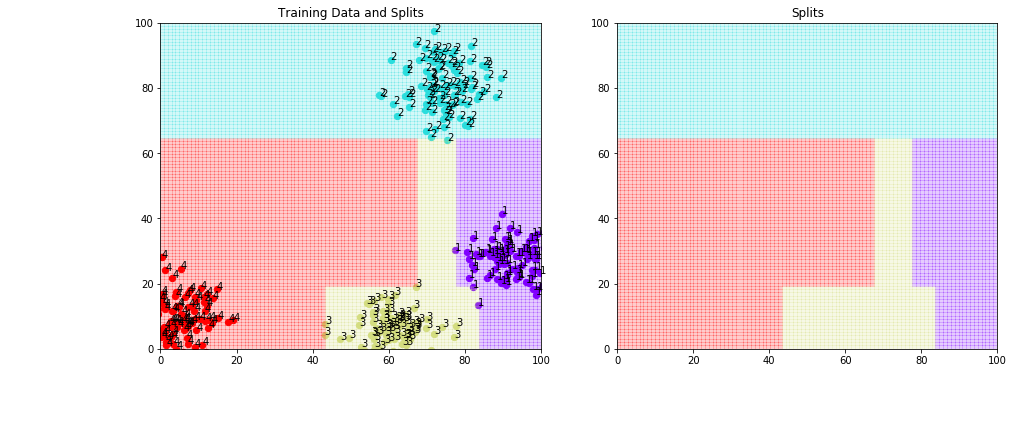

In [13]:
visualize_decision_boundaries(dataset, root, minRange, maxRange)

The overfitting of the tree clearly shows in the decision boundaries above.
# Output the decision forest to a $\LaTeX$ figure

In [14]:
tree_string = ""
tree_string = helpers.printstuff(root,tree_string)

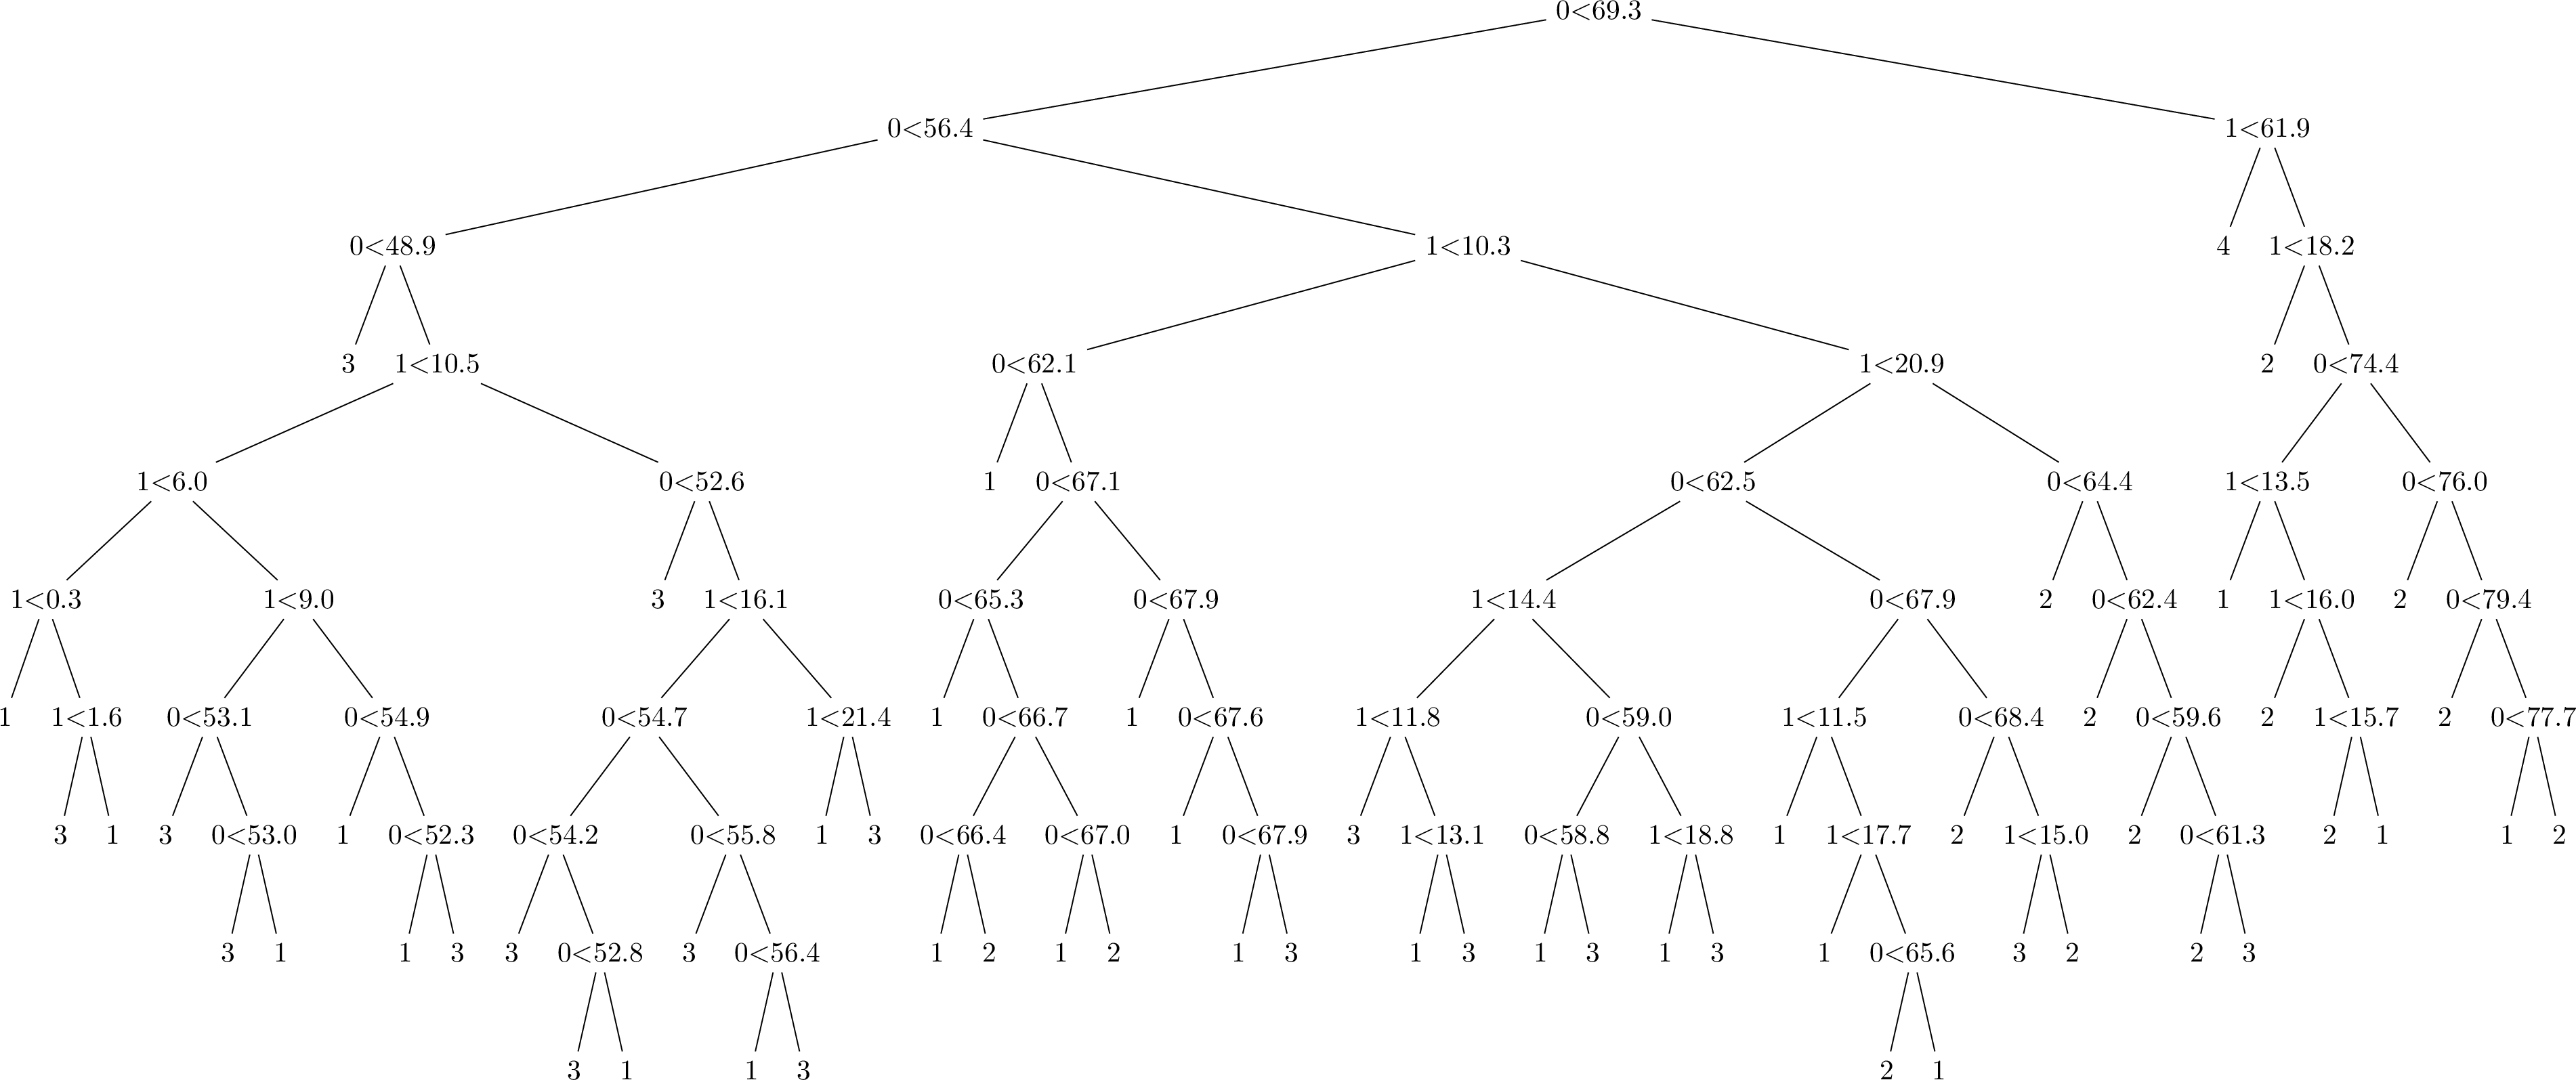

In [ ]:
def tree_visualize(root):
    tree_string = ""
    tree_string = helpers.printstuff(root,tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;  echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)

We can see that the Decision Tree overfits and creates way too many splits. We will thus train many individual trees on a subset of the data.
# Random Forest
- Draw random subsamples of data with replacement
- Create individual decision trees on subsamples
- Visualize decision boundaries

In [ ]:
root_nodes = random_forest.random_forest_build(dataset,1000,.3)

A Jupyter Widget

In [ ]:
# evaluate labels of original dataset using RF
dataset_test = dataset[:,:2]
dataset_eval = random_forest.random_forest_traverse(dataset_test,root_nodes)

In [ ]:
# show data using Random Forests
visualize_decision_boundaries(dataset_eval, root_nodes, minRange, maxRange, rf = True)

In [ ]:
# compare to using only one decision tree:
visualize_decision_boundaries(dataset, root, minRange, maxRange)